# Met Office WOW Exploration

______________________________________________________________________

In this notebook, data from [WOW](https://www.wow.metoffice.gov.uk/) (The service acting as the point of access for crowd sourced recent and historical weather observations) is explored through various plots that visualize the data. The tools used for exploration and plotting are: [Matplotlib](https://matplotlib.org/), and [Pandas](https://pandas.pydata.org)

### Prerequisites

To follow along with this notebook, data from [WOW](https://www.wow.metoffice.gov.uk/) must be downloaded, the general steps for doing so are as follows:

- Create an account on [WOW](https://www.wow.metoffice.gov.uk/) and log in
- Find desired sites and make sure the site reports desired parameter data during desired time selection viewable in the tables tab within the specific site view
- Download site [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) data using the export function (which export only appears once logged in)
- Place the downloaded data in the relevant directory

## Contents

- Explore [WOW](https://www.wow.metoffice.gov.uk/) Data
  - Single Site
    - Load in Pre-Downloaded Data
    - Format and Explore the Data
      - Show Data Issue: Missing Observations
    - Plot the Data with Rolling Mean for Averages (which is an incorrect implementation due to missing data)
  - Multi Site
    - Load and Merge Data
      - Ensure no Duplicate Data has been Loaded
    - Plot Multi Site Information
      - (Optionally use [DataHub](https://metoffice.apiconnect.ibmcloud.com/metoffice/production/) to yield closest Met Office Observational Site Name)
    - Prune Data to Leave Desired Data
    - Plot Desired Data as a Whole (Messy)
    - Separate Data by Month per Site
    - Plot All Sites on a Separate plot for each Month (Cleaner)

In [1]:
# import required packages
import datetime
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In the case of this notebook, the single site data is data downloaded for the entire year of 2021 and the multi site data is downloaded from 4 months across the year of 2019. This information is used in generating the glob patterns below, and should be changed if the data is different to this.

In [2]:
# DEFINE NOTEBOOK SETTINGS
wow_download_dir = "data/WOW"
glob_pattern_for_single_site_data = wow_download_dir + "/*2021*.csv"
multi_site_glob_pattern = wow_download_dir + "/*2019*.csv"

# If this setting does not work, either disable the setting, or successfully get through
# the datahub tutorial
PLOT_SITE_NAMES_MAP = True


if PLOT_SITE_NAMES_MAP:
    import cartopy.crs as ccrs
    import requests

    # clear cell outputs when private API keys are displayed
    from IPython.display import clear_output

    # read environment file
    env_vars = {}

    with open(".env") as f:
        for line in f:
            key, value = line.strip().split("=", 1)
            env_vars[key] = value

    SITE_ID = env_vars["SITE_SPECIFIC_CLIENT_ID"]
    SITE_SECRET = env_vars["SITE_SPECIFIC_CLIENT_SECRET"]
    spot_data_headers = {
        "X-IBM-Client-Id": SITE_ID,
        "X-IBM-Client-Secret": SITE_SECRET,
    }

## Site specific observational data from WOW

### 2021 Whole year, Single Site

#### Load in Pre-Downloaded Data

In [3]:
# define download paths for single site data

csv_files = glob.glob(glob_pattern_for_single_site_data)
print(csv_files)

['data/WOW/North_Wyke_Apr_2021_airtemp.csv', 'data/WOW/North_Wyke_Aug_2021_airtemp.csv', 'data/WOW/North_Wyke_Dec_2021_airtemp.csv', 'data/WOW/North_Wyke_Feb_2021_airtemp.csv', 'data/WOW/North_Wyke_Jan_2021_airtemp.csv', 'data/WOW/North_Wyke_Jul_2021_airtemp.csv', 'data/WOW/North_Wyke_Jun_2021_airtemp.csv', 'data/WOW/North_Wyke_Mar_2021_airtemp.csv', 'data/WOW/North_Wyke_May_2021_airtemp.csv', 'data/WOW/North_Wyke_Nov_2021_airtemp.csv', 'data/WOW/North_Wyke_Oct_2021_airtemp.csv', 'data/WOW/North_Wyke_Sep_2021_airtemp.csv']


In [4]:
# load and save data to a list per file
list_of_dfs_from_csv = []
for csv_path in csv_files:
    df = pd.read_csv(csv_path)
    list_of_dfs_from_csv.append(df)

In [5]:
# show file number
print(len(list_of_dfs_from_csv))

12


In [6]:
# concatenate all data and display the resulting dataframe
df = pd.concat(list_of_dfs_from_csv)
df

,Id,Site Id,Longitude,Latitude,Report Date / Time,Air Temperature,Wet Bulb,Dew Point,Concrete Temp.,Grass Temp.,...,v1_Coastal,v1_Flood,v1_Ice,v1_Landslide,v1_Lightning,v1_PoorVisibility,v1_Snow,v1_Wildfire,v1_Wind,v1_Other
0,﻿20210401azzadaw1tre6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01,10.4,NaN,6.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20210401r67gx5w11ee6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01 01:00:00,10.0,NaN,5.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20210401tg8kd4c1uee6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01 02:00:00,10.1,NaN,5.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,202104011nboyww1uee6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01 03:00:00,8.9,NaN,5.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,202104017pm4gbc1wee6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01 04:00:00,9.6,NaN,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,202109303ib4iptnroe63p5kyyb96spjde,927706001,-3.9,50.767,2021-09-30 19:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708,20210930f58gorjnfwe63p5kyyb96spjde,927706001,-3.9,50.767,2021-09-30 20:00:00,15.3,NaN,14.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,202109301nkybrbngwe63p5kyyb96spjde,927706001,-3.9,50.767,2021-09-30 21:00:00,15.1,NaN,14.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
710,202109306j8bnpjn8we63p5kyyb96spjde,927706001,-3.9,50.767,2021-09-30 22:00:00,14.8,NaN,13.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Format and Explore the Data

In [7]:
# drop columns where all values are NaN
df.dropna(axis=1, how="all", inplace=True)
df

,Id,Site Id,Longitude,Latitude,Report Date / Time,Air Temperature,Dew Point,Mean Sea-Level Pressure,Relative Humidity,Wind Speed,Wind Direction,Wind Gust,Visibility
0,﻿20210401azzadaw1tre6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01,10.4,6.6,1018.0,77.0,5.2,90.0,NaN,7.0
1,20210401r67gx5w11ee6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01 01:00:00,10.0,5.9,1018.0,75.5,4.3,112.5,NaN,8.0
2,20210401tg8kd4c1uee6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01 02:00:00,10.1,5.6,1018.0,73.3,5.2,135.0,NaN,7.0
3,202104011nboyww1uee6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01 03:00:00,8.9,5.9,1018.0,81.2,4.3,90.0,NaN,8.0
4,202104017pm4gbc1wee6znxqyyb96scx3r,927706001,-3.9,50.767,2021-04-01 04:00:00,9.6,6.0,1018.0,78.0,5.2,112.5,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,202109303ib4iptnroe63p5kyyb96spjde,927706001,-3.9,50.767,2021-09-30 19:00:00,NaN,NaN,NaN,NaN,12.2,225.0,NaN,5.0
708,20210930f58gorjnfwe63p5kyyb96spjde,927706001,-3.9,50.767,2021-09-30 20:00:00,15.3,14.3,1013.0,93.7,14.8,247.5,27.8,8.0
709,202109301nkybrbngwe63p5kyyb96spjde,927706001,-3.9,50.767,2021-09-30 21:00:00,15.1,14.0,1013.0,93.1,12.2,247.5,NaN,9.0
710,202109306j8bnpjn8we63p5kyyb96spjde,927706001,-3.9,50.767,2021-09-30 22:00:00,14.8,13.1,1012.0,89.5,12.2,247.5,NaN,9.0


In [8]:
# count NaN values in remaining columns
df.isna().sum()

Id                            0
Site Id                       0
Longitude                     0
Latitude                      0
Report Date / Time            0
Air Temperature              66
Dew Point                    66
Mean Sea-Level Pressure     295
Relative Humidity            66
Wind Speed                 1118
Wind Direction             1118
Wind Gust                  7390
Visibility                    2
dtype: int64

In [9]:
# subset the data to desired columns for exploration
df = df[["Id", "Report Date / Time", "Air Temperature"]]

In [10]:
# show subset
df

,Id,Report Date / Time,Air Temperature
0,﻿20210401azzadaw1tre6znxqyyb96scx3r,2021-04-01,10.4
1,20210401r67gx5w11ee6znxqyyb96scx3r,2021-04-01 01:00:00,10.0
2,20210401tg8kd4c1uee6znxqyyb96scx3r,2021-04-01 02:00:00,10.1
3,202104011nboyww1uee6znxqyyb96scx3r,2021-04-01 03:00:00,8.9
4,202104017pm4gbc1wee6znxqyyb96scx3r,2021-04-01 04:00:00,9.6
...,...,...,...
707,202109303ib4iptnroe63p5kyyb96spjde,2021-09-30 19:00:00,NaN
708,20210930f58gorjnfwe63p5kyyb96spjde,2021-09-30 20:00:00,15.3
709,202109301nkybrbngwe63p5kyyb96spjde,2021-09-30 21:00:00,15.1
710,202109306j8bnpjn8we63p5kyyb96spjde,2021-09-30 22:00:00,14.8


In [11]:
# drop ROWS with NaN values
df = df.dropna(axis=0)
df

,Id,Report Date / Time,Air Temperature
0,﻿20210401azzadaw1tre6znxqyyb96scx3r,2021-04-01,10.4
1,20210401r67gx5w11ee6znxqyyb96scx3r,2021-04-01 01:00:00,10.0
2,20210401tg8kd4c1uee6znxqyyb96scx3r,2021-04-01 02:00:00,10.1
3,202104011nboyww1uee6znxqyyb96scx3r,2021-04-01 03:00:00,8.9
4,202104017pm4gbc1wee6znxqyyb96scx3r,2021-04-01 04:00:00,9.6
...,...,...,...
697,202109309pp3zdbb4ye63p5kyyb96spjde,2021-09-30 09:00:00,13.8
708,20210930f58gorjnfwe63p5kyyb96spjde,2021-09-30 20:00:00,15.3
709,202109301nkybrbngwe63p5kyyb96spjde,2021-09-30 21:00:00,15.1
710,202109306j8bnpjn8we63p5kyyb96spjde,2021-09-30 22:00:00,14.8


In [12]:
# print dataframe (df) length and drop the duplicates, print length of dropped duplicates to show none exist (lengths are equal)
print(len(df))
print(len(df.drop_duplicates()))

8060
8060


#### Show Data Issue: Missing Observations

In [13]:
# count observations for each day, show amount of missing data
expected_observations = 365 * 24  # every day in the year, for 24 hours
print("Expected obs:", expected_observations)

dates_in_df = df["Report Date / Time"].str[0:10]  # yyyy-mm-dd = length 10
df_for_dates = df.copy()
df_for_dates["Report Date / Time"] = dates_in_df
df_for_dates.drop("Air Temperature", axis=1, inplace=True)

date_counter = (
    df_for_dates.groupby("Report Date / Time").count().sort_values(by="Id")
)  # yyyy-mm-dd = length 10

print("counts of observations given on dates:\n", date_counter, "\n")
print("Expected days:", 365)
print("Actual days:", len(date_counter))
print("Missing days:", (365 - len(date_counter)))
print(
    "Existing days with missing data:",
    len(date_counter[date_counter < 24].dropna(axis=0)),
)

Expected obs: 8760
counts of observations given on dates:
                     Id
Report Date / Time    
2021-10-13           2
2021-02-06           7
2021-10-15           7
2021-02-14           9
2021-03-11           9
...                 ..
2021-05-20          24
2021-05-19          24
2021-05-18          24
2021-05-16          24
2021-07-07          24

[349 rows x 1 columns] 

Expected days: 365
Actual days: 349
Missing days: 16
Existing days with missing data: 100


In [14]:
# sort data by time
df = df.sort_values("Report Date / Time")
df.head(25)

,Id,Report Date / Time,Air Temperature
0,﻿20210101xc6kffkm3ye6zd9pyyb96spf9y,2021-01-01,-2.2
1,202101015iwnnm1m4ye6zd9pyyb96spf9y,2021-01-01 01:00:00,-3.1
2,2021010184hssk1m5re6zd9pyyb96spf9y,2021-01-01 02:00:00,-4.1
3,20210101wnhdxd1mhre6zd9pyyb96spf9y,2021-01-01 03:00:00,-2.2
4,20210101yjkyq9nm7ee6zd9pyyb96spf9y,2021-01-01 04:00:00,-1.0
5,20210101as5u5cnm9ee6zd9pyyb96spf9y,2021-01-01 05:00:00,-2.0
6,20210101fs7bxhkcyce6zd9pyyb96spf9y,2021-01-01 06:00:00,-2.8
7,20210101tguprx4cbce6zd9pyyb96spf9y,2021-01-01 07:00:00,-2.2
8,202101016rqre41cnce6zd9pyyb96spf9y,2021-01-01 08:00:00,-1.7
9,2021010169r5soncnce6zd9pyyb96spf9y,2021-01-01 09:00:00,-1.8


In [15]:
# check air temperature is a number instead of string
print(df["Air Temperature"].dtype)

float64


#### Plot of Average Temperatures with Rolling Mean

This implementation is notably incorrect for the earlier issue has not been amended. A rolling mean for a week might span 9 actual days if 2 days of observations out of the 7 days from the start of the rolling mean are missing.

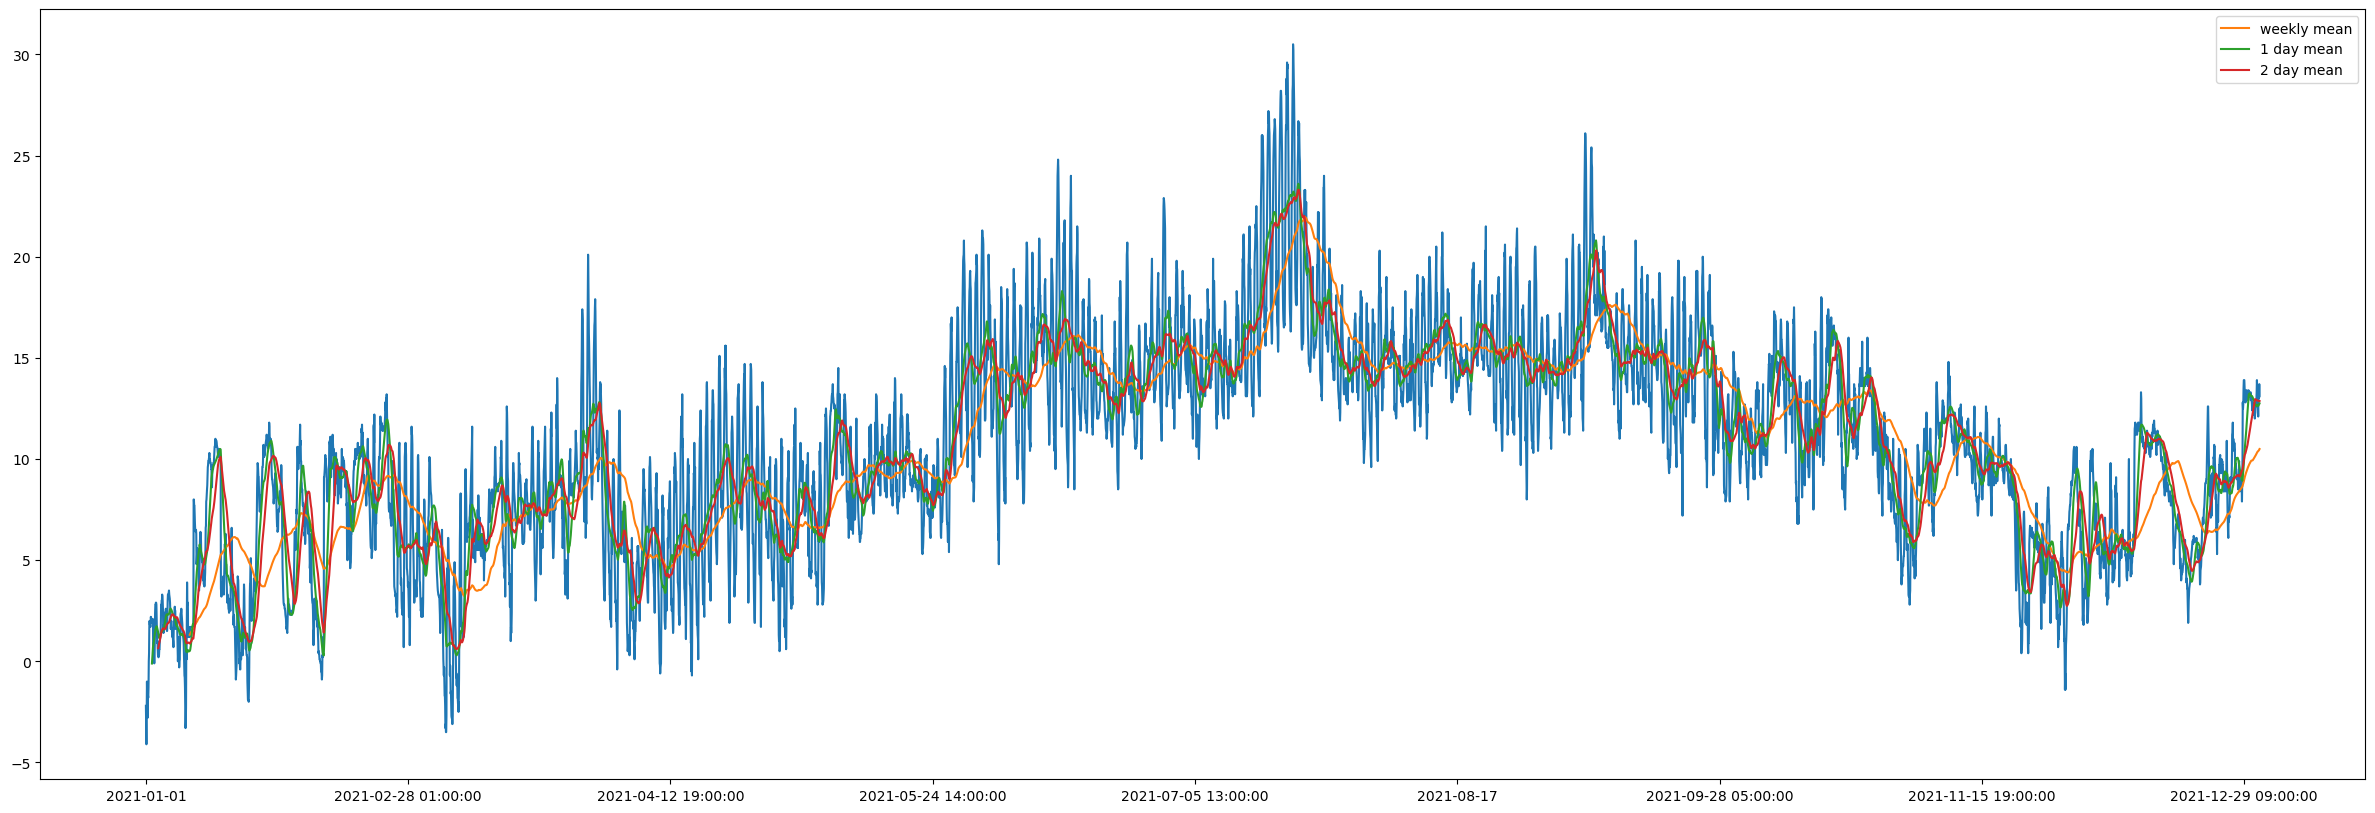

In [16]:
# plot single site data with different rolling means to make better sense of temperatures across longer timescales
plt.figure(figsize=(30, 10))
plt.plot(df["Report Date / Time"], df["Air Temperature"])
# 168 = 24*7 = approx the weekly average temp (inaccurate due to missing data)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(168).mean(),
    label="weekly mean",
)
# similarly 24 is a 1 day mean (due to the expted observation frequency of 1 hour)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(24).mean(),
    label="1 day mean",
)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(48).mean(),
    label="2 day mean",
)
number_of_samples = len(df["Report Date / Time"])
plt.xticks(np.arange(0, number_of_samples, 1000))
plt.legend()
# plt.yticks([])

### Wow data, 2019 Seasonal, 5 sites across England

#### Load and Merge Data into Singular DataFrame

In [17]:
# define filepaths for multiple site data (in this case data taken from 2019 is multi site)
csv_files = glob.glob(multi_site_glob_pattern)
print(csv_files)

['data/WOW/WOW_Andrewsfield_2019_APR.csv', 'data/WOW/WOW_Andrewsfield_2019_JUL.csv', 'data/WOW/WOW_Andrewsfield_2019_OCT.csv', 'data/WOW/WOW_Andrewsfield_2019_JAN.csv', 'data/WOW/WOW_Church-Lawford_2019_APR.csv', 'data/WOW/WOW_Yeovilton_2019_JAN.csv', 'data/WOW/WOW_Church-Lawford_2019_JAN.csv', 'data/WOW/WOW_Church-Lawford_2019_JUL.csv', 'data/WOW/WOW_Church-Lawford_2019_OCT.csv', 'data/WOW/WOW_Leconfield-Sar_2019_APR.csv', 'data/WOW/WOW_Leconfield-Sar_2019_JAN.csv', 'data/WOW/WOW_Leconfield-Sar_2019_JUL.csv', 'data/WOW/WOW_Leconfield-Sar_2019_OCT.csv', 'data/WOW/WOW_Leek_2019_APR.csv', 'data/WOW/WOW_Leek_2019_JAN.csv', 'data/WOW/WOW_Leek_2019_JUL.csv', 'data/WOW/WOW_Leek_2019_OCT.csv', 'data/WOW/WOW_Spadeadam_2019_APR.csv', 'data/WOW/WOW_Spadeadam_2019_JAN.csv', 'data/WOW/WOW_Spadeadam_2019_JUL.csv', 'data/WOW/WOW_Spadeadam_2019_OCT.csv', 'data/WOW/WOW_Yeovilton_2019_APR.csv', 'data/WOW/WOW_Yeovilton_2019_JUL.csv', 'data/WOW/WOW_Yeovilton_2019_OCT.csv']


In [18]:
# read and save data into dfs
list_of_dfs_from_csv = []
for csv_path in csv_files:
    df = pd.read_csv(csv_path)
    list_of_dfs_from_csv.append(df)

In [19]:
# show files loaded
print(len(list_of_dfs_from_csv))

24


In [20]:
# bring all data into a single dataframe
df = pd.concat(list_of_dfs_from_csv)
df

,Id,Site Id,Longitude,Latitude,Report Date / Time,Air Temperature,Wet Bulb,Dew Point,Concrete Temp.,Grass Temp.,...,v1_Coastal,v1_Flood,v1_Ice,v1_Landslide,v1_Lightning,v1_PoorVisibility,v1_Snow,v1_Wildfire,v1_Wind,v1_Other
0,﻿20190401iep9zy1wdwe6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01,2.8,NaN,1.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20190401bxtiyw4wrae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 01:00:00,2.5,NaN,1.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019040136be151wgae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 03:00:00,2.0,NaN,0.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201904015kq8351wgae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 04:00:00,2.0,NaN,0.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20190401gr73xm4w8he6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 05:00:00,1.7,NaN,0.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,20191031gs5dwm8hdwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 19:00:00,10.5,NaN,9.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
732,201910311769ojxhrwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 20:00:00,10.8,NaN,10.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
733,201910319ftjd1zhfwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 21:00:00,10.7,NaN,10.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
734,20191031mchbfzzhgae6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 22:00:00,11.3,NaN,10.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Ensure no Duplicate Data has been Loaded (Manual Verification Through Cell Output)

In [21]:
# show duplicate rows, should be none
df[df.duplicated()]

,Id,Site Id,Longitude,Latitude,Report Date / Time,Air Temperature,Wet Bulb,Dew Point,Concrete Temp.,Grass Temp.,...,v1_Coastal,v1_Flood,v1_Ice,v1_Landslide,v1_Lightning,v1_PoorVisibility,v1_Snow,v1_Wildfire,v1_Wind,v1_Other


#### Plot Multi Site Information

In [22]:
# show the unique lon lat combinations to get the positions of unique sites
lat_lon_df = df[["Longitude", "Latitude"]]
lat_lon_df = lat_lon_df.drop_duplicates()
lat_lon_df

,Longitude,Latitude
0,0.45300,51.89600
0,-1.33000,52.35800
0,-2.64000,51.00600
0,-0.43300,53.86700
0,-1.97993,53.12755
0,-2.55300,55.05000


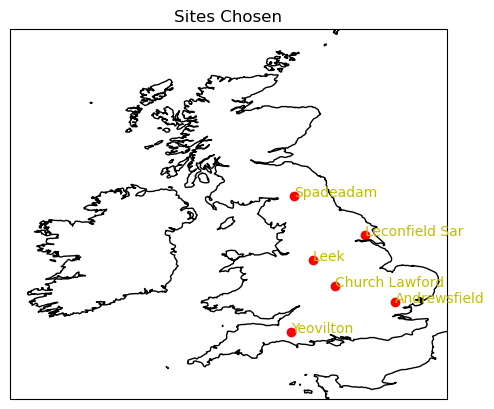

In [23]:
if PLOT_SITE_NAMES_MAP:
    # plot and annotate the site positions on a map, this wastes DataHub requests on just site names.
    # save the site names to a list
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title("Sites Chosen")
    ax.set_extent([-11, 2, 60, 49], ccrs.PlateCarree())  # extent is uk
    plt.scatter(x=lat_lon_df["Longitude"], y=lat_lon_df["Latitude"], color="r")
    ax.coastlines()

    # possible to integrate this with met office datahub api to get location names (not obs site names)
    name_list = []
    for i, (df_ind, (lon, lat)) in enumerate(lat_lon_df.iterrows()):
        params = {
            "includeLocationName": "true",
            "latitude": str(lat),
            "longitude": str(lon),
        }
        # optionally 'waste' datahub site specific requests by getting
        request_url = (
            "https://api-metoffice.apiconnect.ibmcloud.com/v0/forecasts/point/hourly"
        )
        request = requests.get(request_url, params=params, headers=spot_data_headers)
        # the site names for each location ignoring the forecast data returned  #
        name = request.json()["features"][0]["properties"]["location"]["name"]
        name_list.append((name, lon, lat))
        plt.annotate(name, (lon, lat), c="y")

    plt.show()

#### Prune and Format Data to Desired Data for Plotting

In [24]:
# do some data processing, drop columns with all NaNs
df.dropna(axis=1, how="all", inplace=True)
# take all rows where air temp is reported
df = df[df["Air Temperature"].notna()]
df

,Id,Site Id,Longitude,Latitude,Report Date / Time,Air Temperature,Dew Point,Mean Sea-Level Pressure,Relative Humidity,Wind Speed,Wind Direction,Wind Gust,Visibility
0,﻿20190401iep9zy1wdwe6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01,2.8,1.4,1026.0,90.4,7.0,45.0,NaN,8
1,20190401bxtiyw4wrae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 01:00:00,2.5,1.2,1025.0,91.0,7.0,45.0,NaN,7
2,2019040136be151wgae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 03:00:00,2.0,0.9,1024.0,92.2,7.8,45.0,NaN,7
3,201904015kq8351wgae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 04:00:00,2.0,0.9,1024.0,92.2,7.0,45.0,NaN,7
4,20190401gr73xm4w8he6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 05:00:00,1.7,0.8,1024.0,93.6,6.1,45.0,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,20191031gs5dwm8hdwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 19:00:00,10.5,9.8,1015.0,95.4,9.6,112.5,NaN,5
732,201910311769ojxhrwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 20:00:00,10.8,10.1,1014.0,95.4,9.6,112.5,NaN,6
733,201910319ftjd1zhfwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 21:00:00,10.7,10.2,1014.0,96.7,7.8,112.5,NaN,5
734,20191031mchbfzzhgae6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 22:00:00,11.3,10.9,1012.0,97.4,6.1,112.5,NaN,6


In [25]:
df = df.copy()
# add hour minute seconds to data that is missing this information (only at midnight)
# standardize the times (add HH:MM:SS time to days at midnight)
standard_date_series = df["Report Date / Time"].apply(
    lambda x: (x + " 00:00:00") if len(x) == 10 else x
)
df["Report Date / Time"] = standard_date_series
df

,Id,Site Id,Longitude,Latitude,Report Date / Time,Air Temperature,Dew Point,Mean Sea-Level Pressure,Relative Humidity,Wind Speed,Wind Direction,Wind Gust,Visibility
0,﻿20190401iep9zy1wdwe6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 00:00:00,2.8,1.4,1026.0,90.4,7.0,45.0,NaN,8
1,20190401bxtiyw4wrae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 01:00:00,2.5,1.2,1025.0,91.0,7.0,45.0,NaN,7
2,2019040136be151wgae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 03:00:00,2.0,0.9,1024.0,92.2,7.8,45.0,NaN,7
3,201904015kq8351wgae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 04:00:00,2.0,0.9,1024.0,92.2,7.0,45.0,NaN,7
4,20190401gr73xm4w8he6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 05:00:00,1.7,0.8,1024.0,93.6,6.1,45.0,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,20191031gs5dwm8hdwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 19:00:00,10.5,9.8,1015.0,95.4,9.6,112.5,NaN,5
732,201910311769ojxhrwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 20:00:00,10.8,10.1,1014.0,95.4,9.6,112.5,NaN,6
733,201910319ftjd1zhfwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 21:00:00,10.7,10.2,1014.0,96.7,7.8,112.5,NaN,5
734,20191031mchbfzzhgae6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 22:00:00,11.3,10.9,1012.0,97.4,6.1,112.5,NaN,6


In [26]:
# convert data/time string to Date Time python object
str_format = "%Y-%m-%d %H:%M:%S"
df["Report Date / Time"] = df["Report Date / Time"].apply(
    lambda x: datetime.datetime.strptime(x, str_format)
)
print(df["Report Date / Time"].dtype)
df

datetime64[ns]


,Id,Site Id,Longitude,Latitude,Report Date / Time,Air Temperature,Dew Point,Mean Sea-Level Pressure,Relative Humidity,Wind Speed,Wind Direction,Wind Gust,Visibility
0,﻿20190401iep9zy1wdwe6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 00:00:00,2.8,1.4,1026.0,90.4,7.0,45.0,NaN,8
1,20190401bxtiyw4wrae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 01:00:00,2.5,1.2,1025.0,91.0,7.0,45.0,NaN,7
2,2019040136be151wgae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 03:00:00,2.0,0.9,1024.0,92.2,7.8,45.0,NaN,7
3,201904015kq8351wgae6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 04:00:00,2.0,0.9,1024.0,92.2,7.0,45.0,NaN,7
4,20190401gr73xm4w8he6ucn8yyb96scitc,7001,0.453,51.896,2019-04-01 05:00:00,1.7,0.8,1024.0,93.6,6.1,45.0,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,20191031gs5dwm8hdwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 19:00:00,10.5,9.8,1015.0,95.4,9.6,112.5,NaN,5
732,201910311769ojxhrwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 20:00:00,10.8,10.1,1014.0,95.4,9.6,112.5,NaN,6
733,201910319ftjd1zhfwe6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 21:00:00,10.7,10.2,1014.0,96.7,7.8,112.5,NaN,5
734,20191031mchbfzzhgae6uqdnyyb96sc6rw,1040,-2.640,51.006,2019-10-31 22:00:00,11.3,10.9,1012.0,97.4,6.1,112.5,NaN,6


In [27]:
# take only the desired data for plots, sort data
sub_df_for_plot = df[["Site Id", "Report Date / Time", "Air Temperature"]]
sub_df_for_plot = sub_df_for_plot.sort_values(by="Report Date / Time")  # sort by date
sub_df_for_plot

,Site Id,Report Date / Time,Air Temperature
0,7007,2019-01-01 00:00:00,8.3
0,7001,2019-01-01 00:00:00,8.1
0,1040,2019-01-01 00:00:00,8.8
0,7011,2019-01-01 00:00:00,9.1
0,5018,2019-01-01 00:00:00,6.9
...,...,...,...
731,5018,2019-10-31 23:00:00,6.2
734,7007,2019-10-31 23:00:00,7.5
731,32,2019-10-31 23:00:00,5.1
734,7011,2019-10-31 23:00:00,7.9


In [28]:
# drop all rows with NaN values, get a seperate dataframe per site
sub_df_for_plot = sub_df_for_plot.dropna(axis=0)
plot_by_site = dict(tuple(sub_df_for_plot.groupby("Site Id")))

In [29]:
# convert the site grouped dataframes into a list
df_list = []
for values in plot_by_site.values():
    df_list.append(pd.DataFrame(values))
df_list[0]

,Site Id,Report Date / Time,Air Temperature
0,32,2019-01-01 00:00:00,7.3
1,32,2019-01-01 01:00:00,7.3
2,32,2019-01-01 02:00:00,7.4
3,32,2019-01-01 03:00:00,7.5
4,32,2019-01-01 04:00:00,7.6
...,...,...,...
727,32,2019-10-31 19:00:00,5.8
728,32,2019-10-31 20:00:00,5.3
729,32,2019-10-31 21:00:00,4.9
730,32,2019-10-31 22:00:00,4.9


#### Plot Desired Data as a Whole

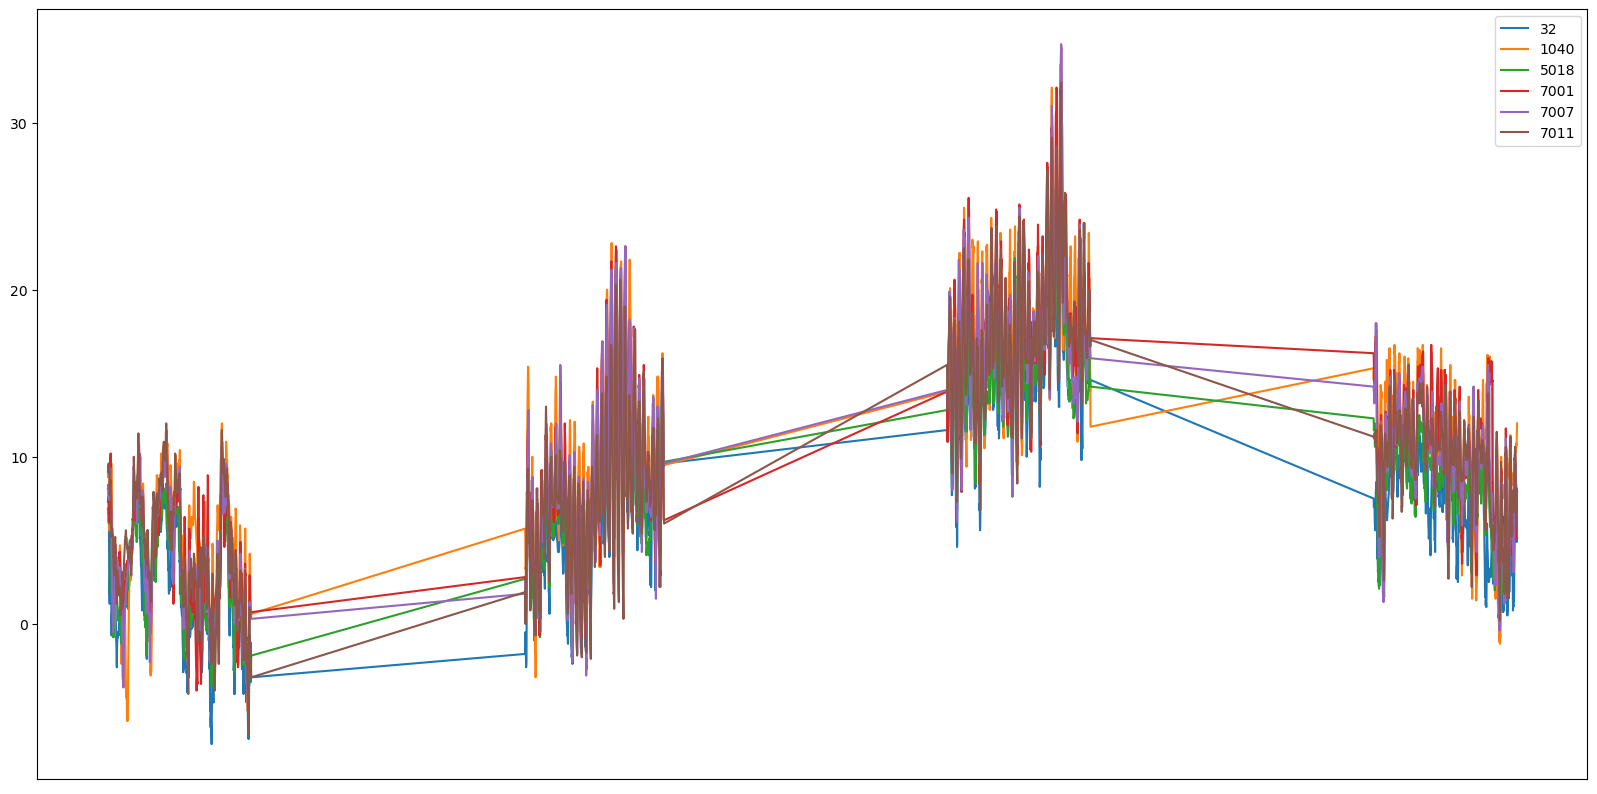

In [30]:
# plot each site into one figure
plt.figure(figsize=(20, 10))
for df in df_list:
    plt.plot(
        df["Report Date / Time"], df["Air Temperature"], label=df["Site Id"].iloc[0]
    )
plt.xticks([])
plt.legend()

#### Separate Data by Month per Site

In [31]:
# further group data by month (grouped by site first, then month)
i = 0
for site in df_list:
    site["month"] = site["Report Date / Time"].apply(lambda x: x.month)
    seasonal = dict(tuple(site.groupby("month")))
    season_list = []
    for values in seasonal.values():
        season_list.append(pd.DataFrame(values))
    df_list[i] = season_list  # dynamically typed magic, or just bad practice?
    # print(i)
    i += 1
del i

#### Plot Separated Data in Individual Figures

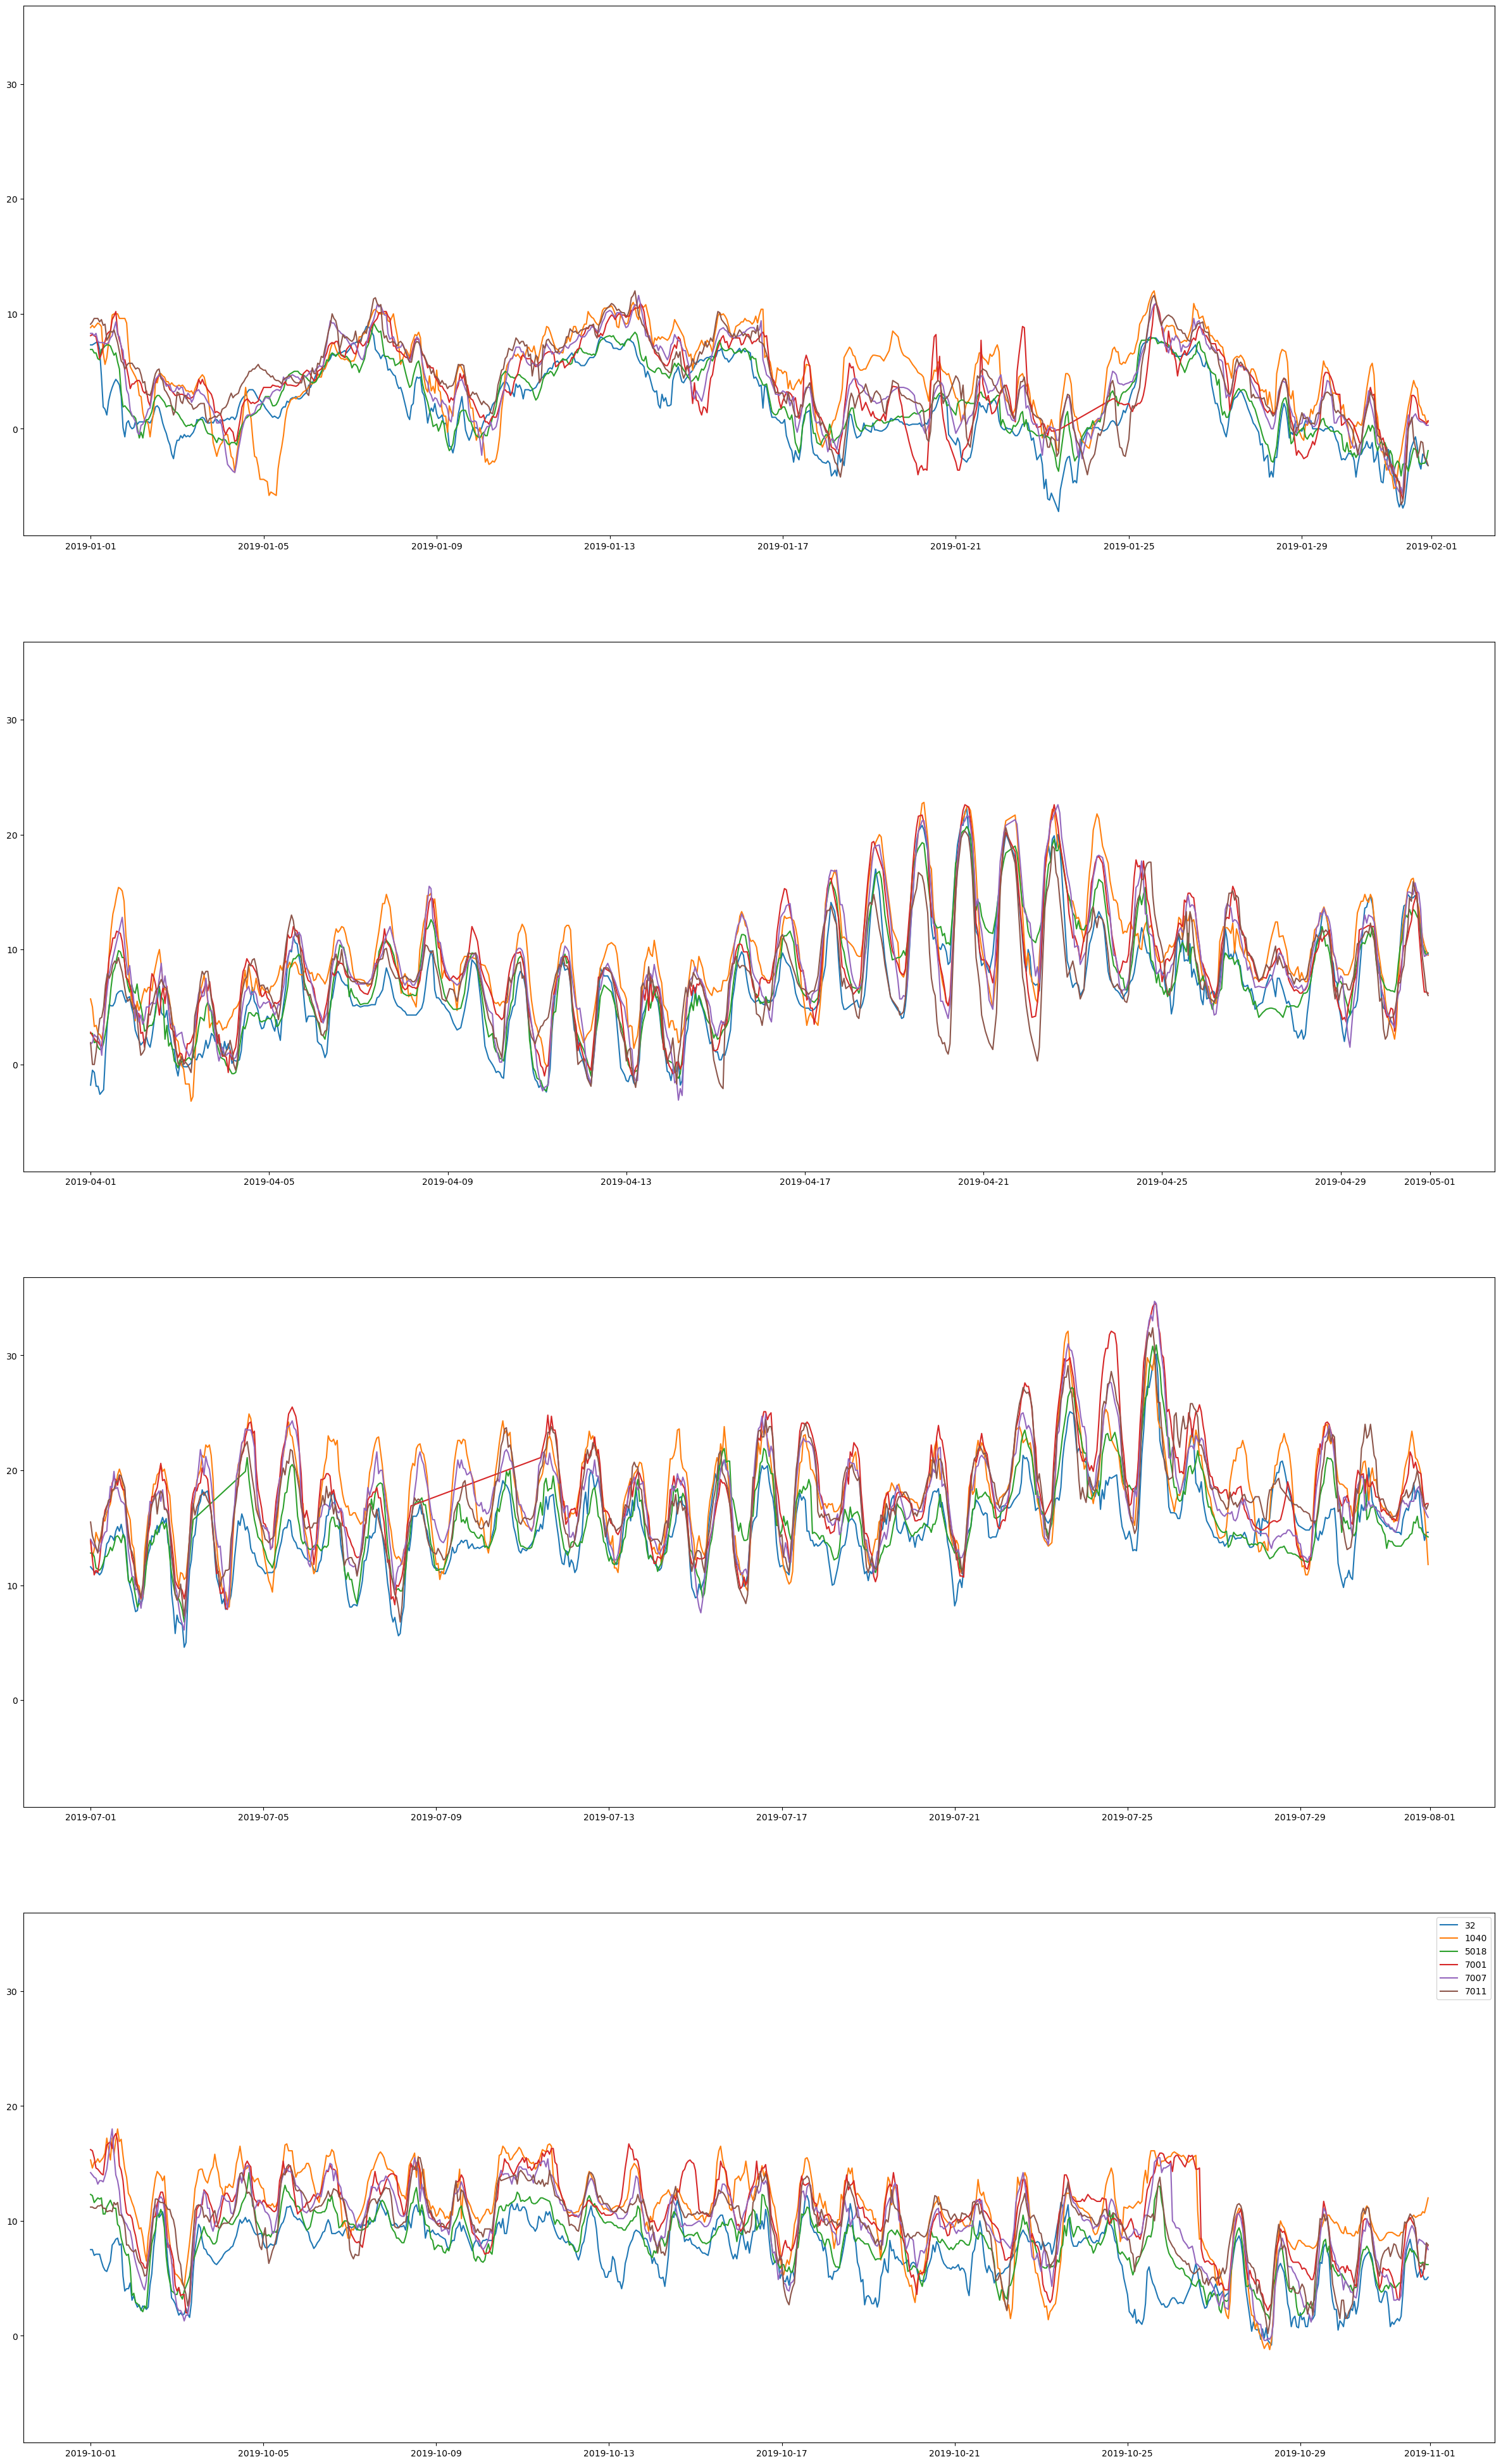

In [32]:
# plot the site, month grouping of data across month based plots
fig, axes = plt.subplots(
    nrows=len(df_list[0]), ncols=1, figsize=(30, 50), sharex=False, sharey=True
)

for i, ax in enumerate(axes.flatten()):
    for j in range(len(df_list)):
        ax.plot(
            df_list[j][i]["Report Date / Time"],
            df_list[j][i]["Air Temperature"],
            label=df_list[j][i]["Site Id"].iloc[0],
        )
plt.legend()

## Data Statement

__Contains public sector information licensed under the Open Government Licence v3.0.__

(20th September 2022, paraphrased) When interacting with WOW data, Unless indicated otherwise, WOW data are licensed under the Open Government Licence; please see the Open Government Licence.

- Link to Open Government Licence: https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/
- Link to WOW licence: https://wow.metoffice.gov.uk/support/licence
- Source of Data: https://wow.metoffice.gov.uk

______________________________________________________________________

## References

- [WOW](https://www.wow.metoffice.gov.uk/)
- [CSV File Format](https://en.wikipedia.org/wiki/Comma-separated_values)
- [Pandas](https://pandas.pydata.org)
- [Matplotlib](https://matplotlib.org/)
- [DataHub](https://metoffice.apiconnect.ibmcloud.com/metoffice/production/)